# Grid world 
Navigation in gridworld !
The agent has four possible actions in each state (grid square NxN): west, north, south, and east. The initial state of the agent is (0, 0). The grid squares with the gold and the bomb are terminal states. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.


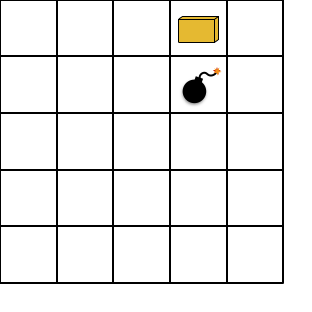

### Import Libraries

In [3]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

### Q learning, Sarsa , Double Q learning

In [144]:
class GridWorld():
  def __init__(self) :
    # Khởi tạo thông tin của grid
    self.W=10
    self.H=10
    self.grid=np.zeros((self.H, self.W)) -1   # tất cả các ô đều có điểm thưởng là -1
    self.cur_location= (0,0)

    #Tạo điểm đích và boom
    self.boom1_location=(7,9)
    self.boom2_location=(8,6)
    self.goal_location=(8,9)

    #Tạo điểm thưởng cho 2 trạng thái kết thúc
    self.grid[self.boom1_location[0],self.boom1_location[1]] = -10
    self.grid[self.boom2_location[0],self.boom2_location[1]] = -10
    self.grid[self.goal_location[0],self.goal_location[1]] = 10
    self.terminal_state= [self.boom1_location,self.boom2_location, self.goal_location]

    #tập các hành động
    self.actions=["Up","Down","Left","Right"]
  def get_reward(self, new_location):
    return self.grid[new_location[0],new_location[1]]
  def step(self, action):
    #luu tru vi tri cu
    last_location=self.cur_location
    # Up
    if action=="Up":
      if last_location[0] == self.W-1:
        reward= self.get_reward(last_location)
      else :
        self.cur_location= (self.cur_location[0]+1,self.cur_location[1])
        reward = self.get_reward(self.cur_location)
    # Down
    if action=="Down":
      if last_location[0] == 0:
        reward = self.get_reward(last_location)
      else :
        self.cur_location= (self.cur_location[0]-1,self.cur_location[1])
        reward=self.get_reward(self.cur_location)
    # Left
    if action == "Left" :
      if last_location[1] == 0 :
        reward = self.get_reward(last_location)
      else:
        self.cur_location= (self.cur_location[0],self.cur_location[1]-1)
        reward = self.get_reward(self.cur_location)
    # Right
    if action == "Right" :
      if last_location[1] == self.H-1 :
        reward = self.get_reward(last_location)
      else :
        self.cur_location= (self.cur_location[0],self.cur_location[1]+1)
        reward = self.get_reward(self.cur_location)
    return reward
    #Kiểm tra xem có đang ở trạng thái kết thúc hay không
  def check_state(self):
    if self.cur_location in self.terminal_state :
      return 1
    return 0


In [7]:
class Q_agent:
  #Khoi tao
  def __init__(self,environment, epsilon=0.05,learning_rate=0.1,gamma=0.9) :
    self.environment = environment
    self.q_table = dict()
    for i in range(self.environment.H):
      for j in range(self.environment.W):
        self.q_table[(i,j)] = {"Up":0,"Down" : 0, "Left":0,"Right":0}
    self.epsilon=epsilon
    self.learning_rate=learning_rate
    self.gamma=gamma

  #chon hanh dong
  def choose_action(self) :
    if np.random.uniform(0,1) < self.epsilon :
      action = self.environment.actions[np.random.randint(0,4)]
    else :
      q_value_of_state = self.q_table[self.environment.cur_location]
      maxValue = max(q_value_of_state.values())
      action = np.random.choice([k for k, v in q_value_of_state.items() if v == maxValue])
    return action
  
  # Cập nhật giá trị hàm Q thông qua q_table
  def learn(self,old_state,action,new_state,reward):
    new_q_value_state = self.q_table[new_state]
    new_q_value = max(new_q_value_state.values())
    u = new_q_value*self.gamma + reward
    cur_q_value = self.q_table[old_state][action]

    self.q_table[old_state][action] = cur_q_value + self.learning_rate*(u-cur_q_value)

In [6]:
class Double_Q_agent:
  #Khoi tao
  def __init__(self, environment, epsilon=0.05,learning_rate=0.1,gamma=0.9) :
    self.environment = environment
    self.q_table1 = dict()
    self.q_table2=dict()
    for i in range(self.environment.H):
      for j in range(self.environment.W):
        self.q_table1[(i,j)] = {"Up":0,"Down" : 0, "Left":0,"Right":0}
        self.q_table2[(i,j)] = {"Up":0,"Down" : 0, "Left":0,"Right":0}
    self.epsilon=epsilon
    self.learning_rate=learning_rate
    self.gamma=gamma

  def choose_action(self) :
    if np.random.uniform(0,1) < self.epsilon :
      action = self.environment.actions[np.random.randint(0,4)]
    else :
      q1_action_values = self.q_table1[self.environment.cur_location]
      q2_action_values = self.q_table2[self.environment.cur_location]
      sum_q = q1_action_values.copy()
      sum_q.update(q2_action_values)
      maxValue = max(sum_q.values())
      action = np.random.choice([k for k, v in sum_q.items() if v == maxValue])
    return action
  
  # Cập nhật giá trị hàm Q thông qua q_table
  def learn(self,old_state,action,new_state,reward):
    if np.random.uniform(0.1) < 0.5 :
      new_q_value_state = self.q_table1[new_state]
      maxValue = max(new_q_value_state.values())
      next_action = np.random.choice([i for i, value in new_q_value_state.items() if value == maxValue])
      u = self.q_table2[new_state][next_action]*self.gamma + reward
      cur_q_value = self.q_table1[old_state][action]
      self.q_table1[old_state][action] = cur_q_value + self.learning_rate*(u - cur_q_value)
    else :
      new_q_value_state = self.q_table2[new_state]
      maxValue = max(new_q_value_state.values())
      next_action = np.random.choice([i for i, value in new_q_value_state.items() if value == maxValue])
      u = self.q_table1[new_state][next_action]*self.gamma + reward
      cur_q_value = self.q_table2[old_state][action]
      self.q_table2[old_state][action] = cur_q_value + self.learning_rate*(u - cur_q_value)

In [12]:
class Sarsa_agent:
  #Khoi tao
  def __init__(self,environment, epsilon=0.05,learning_rate=0.1,gamma=0.9) :
    self.environment = environment
    self.q_table = dict()
    for i in range(self.environment.H):
      for j in range(self.environment.W):
        self.q_table[(i,j)] = {"Up":0,"Down" : 0, "Left":0,"Right":0}
    self.epsilon=epsilon
    self.learning_rate=learning_rate
    self.gamma=gamma

  #chon hanh dong
  def choose_action(self) :
    if np.random.uniform(0,1) < self.epsilon :
      action = self.environment.actions[np.random.randint(0,4)]
    else :
      q_value_of_state = self.q_table[self.environment.cur_location]
      maxValue = max(q_value_of_state.values())
      action = np.random.choice([k for k, v in q_value_of_state.items() if v == maxValue])
    return action
  
  # Cập nhật giá trị hàm Q thông qua q_table
  def learn(self,old_state,old_action,new_action,new_state,reward):
    new_q_value_state = self.q_table[new_state]
    new_q_value = new_q_value_state[new_action]
    u = new_q_value*self.gamma + reward
    cur_q_value = self.q_table[old_state][old_action]
    self.q_table[old_state][old_action] = cur_q_value + self.learning_rate*(u-cur_q_value)


In [115]:
def Sarsa_play(environment, agent, trials, step_per_episode) :
  reward_per_episode = []
  #khởi chạy từng lần lặp
  for trial in range(trials):
    environment.__init__()
    cumurative_reward = 0
    step = 0
    old_action= agent.choose_action()
    while step < step_per_episode :
      old_state = environment.cur_location
      reward = environment.step(old_action)
      new_action = agent.choose_action()
      new_state = environment.cur_location
      agent.learn(old_state, old_action, new_action, new_state, reward)
      old_action = new_action
      cumurative_reward += reward
      step +=1
      if environment.check_state() == 1 :
        break
    reward_per_episode.append(cumurative_reward)
  return reward_per_episode

In [116]:
def play(environment, agent, trials, step_per_episode ) :
  reward_per_episode = []
  #khởi chạy từng lần lặp
  for trial in range(trials):
    environment.__init__()
    cumurative_reward = 0
    step = 0
    while step < step_per_episode :
      old_state = environment.cur_location
      action = agent.choose_action()
      reward = environment.step(action)
      new_state = environment.cur_location
      agent.learn(old_state,action,new_state,reward)
      cumurative_reward += reward
      step +=1
      if environment.check_state() == 1 :
        break
    reward_per_episode.append(cumurative_reward)
  return reward_per_episode


In [147]:
environment = GridWorld()
Sarsa_a = Sarsa_agent(environment)
reward_per_episode_sarsa = Sarsa_play(environment, Sarsa_a, 500, 500)

agentQ = Q_agent(environment)
reward_per_episode_Q = play(environment, agentQ, 500, 500)

double_q = Double_Q_agent(environment)
reward_per_episode_2Q = play(environment, double_q, 500, 500)

### Visualize

best reward :  -6.0


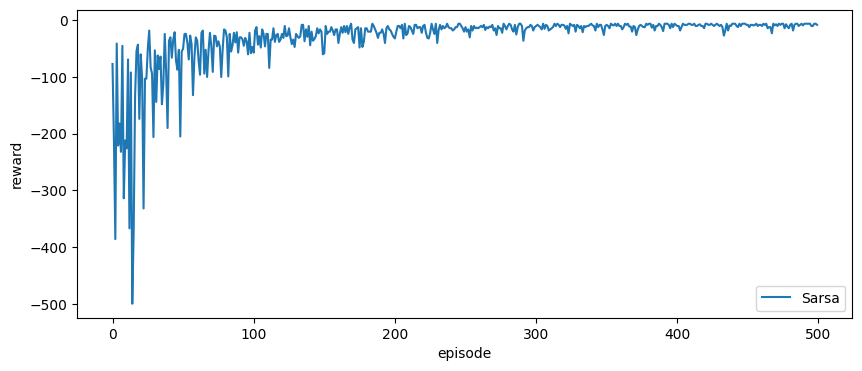

best reward :  -6.0


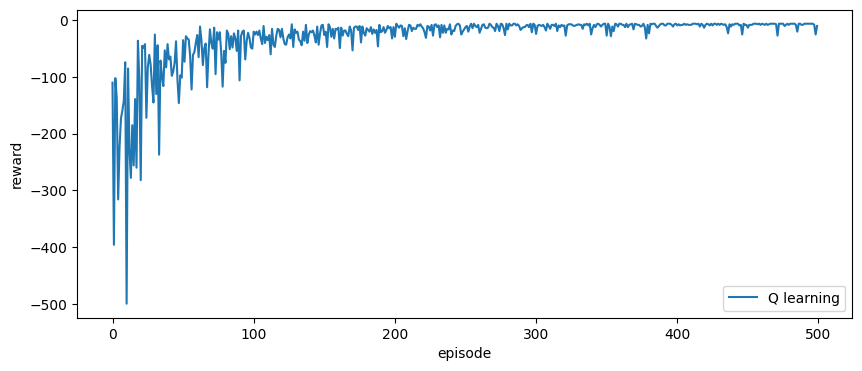

best reward :  -6.0


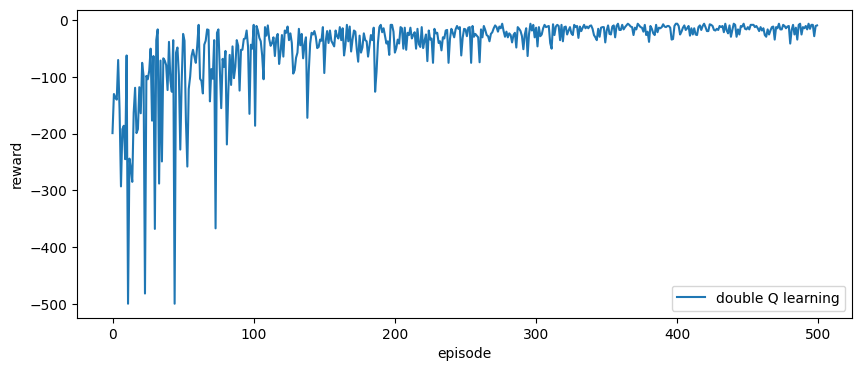

In [148]:
print("best reward : ",max(reward_per_episode_sarsa))
plt.figure(figsize=(10,4))
plt.plot(reward_per_episode_sarsa, label = "Sarsa")
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

print("best reward : ",max(reward_per_episode_Q))
plt.figure(figsize=(10,4))
plt.plot(reward_per_episode_Q, label = "Q learning")
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

print("best reward : ",max(reward_per_episode_2Q))
plt.figure(figsize=(10,4))
plt.plot(reward_per_episode_2Q, label = "double Q learning")
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()